<a href="https://colab.research.google.com/github/ericphann/voice-sentiment-analysis/blob/main/mfcc_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Eric Phann / Jessica Ricks  
DSBA 6156: Applied Machine Learning

# 🔉 Approach #2: Mel-Frequency Cepstral Coefficients

This notebook will show how to extract features from the audio sample using Mel-Frequency Cepstral coefficients and train a neural network to classify sentiment.

## 1. Installing dependencies

We will install dependencies and use Cuda to speed up the training process.

In [1]:
import os
import numpy as np
import librosa
import librosa.display
import torch
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings('ignore')

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU detected:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("No GPU detected, using CPU.")

GPU detected: Tesla T4


## 2. Import and preprocess dataset

We first import the RAVDESS dataset from Kaggle.

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("uwrfkaggler/ravdess-emotional-speech-audio")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1


We then create a function to extract the ground truth emotion from the file name. For more information please see the [RAVDESS page](https://zenodo.org/records/1188976).

In [4]:
def extract_emotion(file_name):
    emotion_map = {
        "01": "Neutral",
        "02": "Calm",
        "03": "Happy",
        "04": "Sad",
        "05": "Angry",
        "06": "Fearful",
        "07": "Disgust",
        "08": "Surprised",
    }
    emotion_code = file_name.split("-")[2]  # Third element in file name
    return emotion_map[emotion_code]

To be able to use these labels for sentiment analysis, we will need to classify them as positive, negative, or neutral as follows:


*   Positive: happy, surprised
*   Neutral: neutral, calm
*   Negative: sad, angry, fearful, disgust  

These groupings are purely based on intuition.



Let's create a function to map sentiments based on the emotions.

In [5]:
def map_to_sentiment(emotion):
    if emotion in ["Happy", "Surprised"]:
        return "Positive"
    elif emotion in ["Sad", "Angry", "Fearful", "Disgust"]:
        return "Negative"
    else:
        return "Neutral"

We also will create a function to extract [Mel Frequency Cepstral Coefficients](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum) (MFCC) from the audio files. At a high level, MFCC is a representation of the short-term power spectrum of a sound. This is commonly used in speech processing tasks such as voice recognition. The standard for the spectrogram is 12-13 MFCCs. Below is an example image.

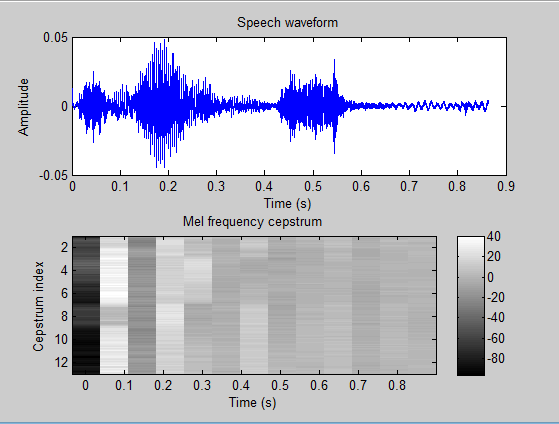

In [6]:
def extract_mfcc(file_path, max_pad_len=174):
    try:
        audio, sample_rate = librosa.load(file_path, sr=16000)
        mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=12) # extract 12 MFCC: the standard is 12-13
        pad_width = max_pad_len - mfcc.shape[1]
        if pad_width > 0:
            mfcc = np.pad(mfcc, ((0, 0), (0, pad_width)), mode='constant')
        else:
            mfcc = mfcc[:, :max_pad_len]
        return mfcc
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

Now, let's preprocess our dataset using these functions.

In [7]:
import os
import pandas as pd
!pip install resampy
!pip install tqdm
import resampy
from tqdm import tqdm

results = []

audio_dir = "/root/.cache/kagglehub/datasets/uwrfkaggler/ravdess-emotional-speech-audio/versions/1"
for subdir, dirs, files in tqdm(list(os.walk(audio_dir))):
    for file in files:
        if file.endswith(".wav"):
            path = os.path.join(subdir, file)
            emotion = extract_emotion(file)
            sentiment = map_to_sentiment(emotion)

            # Extract MFCC from the audio file
            mfcc =  extract_mfcc(path)

            # Save results
            results.append({
                "File": file,
                "True Emotion": emotion,
                "True Sentiment": sentiment,
                "MFCC": mfcc
            })

df = pd.DataFrame(results)
df.to_csv("ravdess_MFCC.csv", index=False)

100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


In [8]:
df.head(10)

,File,True Emotion,True Sentiment,MFCC
0,03-01-05-02-02-02-04.wav,Angry,Negative,"[[-676.31586, -676.31586, -676.31586, -676.315..."
1,03-01-08-01-01-01-04.wav,Surprised,Positive,"[[-789.8456, -789.8456, -789.8456, -789.8456, ..."
2,03-01-03-01-01-02-04.wav,Happy,Positive,"[[-784.54974, -784.54974, -784.54974, -784.549..."
3,03-01-02-02-01-01-04.wav,Calm,Neutral,"[[-866.01416, -866.01416, -866.01416, -866.014..."
4,03-01-04-01-01-02-04.wav,Sad,Negative,"[[-756.0085, -756.0085, -756.0085, -756.0085, ..."
5,03-01-08-02-01-02-04.wav,Surprised,Positive,"[[-643.07825, -643.07825, -643.07825, -643.078..."
6,03-01-04-02-02-02-04.wav,Sad,Negative,"[[-659.72144, -659.72144, -659.72144, -659.721..."
7,03-01-07-02-02-02-04.wav,Disgust,Negative,"[[-713.161, -713.161, -713.161, -713.161, -713..."
8,03-01-04-02-01-02-04.wav,Sad,Negative,"[[-647.8507, -644.9554, -645.64307, -648.4372,..."
9,03-01-03-01-02-01-04.wav,Happy,Positive,"[[-820.6902, -820.6902, -820.6902, -820.6902, ..."


Let's take a look at what the MFCC looks like.

In [9]:
print(df.loc[0, 'MFCC'])

[[-676.31586 -676.31586 -676.31586 ...    0.         0.         0.     ]
 [   0.         0.         0.      ...    0.         0.         0.     ]
 [   0.         0.         0.      ...    0.         0.         0.     ]
 ...
 [   0.         0.         0.      ...    0.         0.         0.     ]
 [   0.         0.         0.      ...    0.         0.         0.     ]
 [   0.         0.         0.      ...    0.         0.         0.     ]]


In [10]:
print(df.loc[0, 'MFCC'].shape)

(12, 174)


Great -- now let's build our train/test sets!

In [11]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Extract MFCCs and labels
X = np.array(df['MFCC'].tolist())  # MFCCs should already be stored as numpy arrays
y = np.array(df['True Sentiment'].tolist())  # Sentiment labels

# Check the shape of the MFCCs (should be 2D per sample, e.g., (12, 174))
print(f"MFCC shape: {X[0].shape}")

# Reshape X for CNN input (adding a channel dimension)
X = X[..., np.newaxis]

# One-hot encode the labels
for sentiment in y:
    if sentiment == "Positive":
        y[y == sentiment] = 2
    elif sentiment == "Neutral":
        y[y == sentiment] = 1
    elif sentiment == "Negative":
        y[y == sentiment] = 0

y = to_categorical(y, num_classes=3) # this will encode each class as a (1,3) array

# Split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")


MFCC shape: (12, 174)
Training data shape: (2304, 12, 174, 1)
Test data shape: (576, 12, 174, 1)


If 1 is in the first column, it is Negative. If it is in the second column, it is Neutral. If it is in the third column, it is Positive.

In [12]:
print(y)

[[1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


## 3. Build & Train a CNN

Let's make sure we use our GPU to speed up training.

In [13]:
# Check if TensorFlow is detecting the GPU
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(f"GPU available: {physical_devices}")
else:
    print("No GPU found.")

GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Adjust input shape to reflect (174, 12) MFCC data
# Input shape: (time steps, MFCC coefficients, channels)
input_shape = (174, 12, 1)  # 174 time steps, 12 MFCC coefficients, 1 channel (grayscale-like)

# Build the CNN model
model = Sequential([
    # First Conv2D layer
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
    MaxPooling2D((2, 2)),  # Max pooling layer to reduce dimensions

    # Second Conv2D layer
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Third Conv2D layer
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    # Flatten layer to convert 2D matrices into 1D feature vector
    Flatten(),

    # Fully connected dense layer
    Dense(128, activation='relu'),

    # Dropout layer for regularization
    Dropout(0.5),

    # Output layer with softmax activation for multi-class classification
    Dense(3, activation='softmax')  # Output layer for 3 classes (Negative, Neutral, Positive)
])

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 174, 12, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 87, 6, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 87, 6, 64)           │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 43, 3, 64)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 43, 3, 128)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 21, 1, 128)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2688)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         344,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 437,251 (1.67 MB)

 Trainable params: 437,251 (1.67 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.4508 - loss: 10.4853 - val_accuracy: 0.4809 - val_loss: 0.9593
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.5260 - loss: 0.9402 - val_accuracy: 0.5712 - val_loss: 0.8828
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5381 - loss: 0.8922 - val_accuracy: 0.5990 - val_loss: 0.8087
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5892 - loss: 0.8339 - val_accuracy: 0.5781 - val_loss: 0.7475
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5656 - loss: 0.7692 - val_accuracy: 0.6684 - val_loss: 0.6560
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6020 - loss: 0.7392 - val_accuracy: 0.6667 - val_loss: 0.6628
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6070 - loss: 0.7233 - val_accuracy: 0.7049 - val_loss: 0.6085
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6667 - loss: 0.6405 - val_accuracy: 0.6545 - val_los

Great -- after 10 epochs we can see that our fully trained model has about 78% accuracy on our test set! This is way better than the 50% accuracy we saw with simple raw-text sentiment analysis, suggesting that there is signal in the dataset which cannot be captured in raw test.

## 4. Save our model and upload to Hugging Face

Now that we have a CNN model trained on MFCC for sentiment analysis, let's save it to Hugging Face so we can use it in our Streamlit app.

In [38]:
model.save("RAVDESS_MFCC_Sentiment_Analysis.keras")

Now, we can take this keras file and upload it to the Hugging Face repo. Here is the link to the [RAVDESS MFCC Sentiment Analysis model repo](https://huggingface.co/ericphann/RAVDESS_MFCC_Sentiment_Analysis).